# Data Structuring and Analysis

In [43]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jashwanthreddya/youtube")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\glint\.cache\kagglehub\datasets\jashwanthreddya\youtube\versions\1


In [48]:
import pandas as pd
from  pathlib import Path

In [ ]:
dataset_dir = Path("/Users/hanane/.cache/kagglehub/datasets/jashwanthreddya/youtube/versions/1")
csv_path = next(dataset_dir.glob("*.csv"))

In [49]:
csv_path = Path(r"C:\Users\glint\OneDrive\Documents\Ironhack lessons\Youtube_dataset\DATASET.csv")
print(csv_path)

C:\Users\glint\OneDrive\Documents\Ironhack lessons\Youtube_dataset\DATASET.csv


In [50]:
df = pd.read_csv(csv_path)

In [51]:
#1 csv with the categories:
csv_path1 = Path(r"C:\Users\glint\OneDrive\Documents\Ironhack lessons\Youtube_dataset\video_categories.csv")
#2 csv with the dataset:
csv_path = Path(r"C:\Users\glint\OneDrive\Documents\Ironhack lessons\Youtube_dataset\DATASET.csv")
#3 csv with the subscribers:
csv_path2 = Path(r"C:\Users\glint\OneDrive\Documents\Ironhack lessons\Youtube_dataset\subscribers.csv")

In [52]:
df_data = pd.read_csv(csv_path)
df_categories = pd.read_csv(csv_path1)
df_subscribers = pd.read_csv(csv_path2)

In [53]:
df_new = pd.merge(df_data, df_categories, 
                  on="video_id", 
                  how="left")
df_new.head(1)

,video_id,title,channel_id,channel_title,published_at,view_count,likes,dislikes,comment_count,tags,description,comments,category_id,category_name
0,--0bCF-iK2E,Jadon Sancho Magical Skills & Goals,UC6UL29enLNe4mqwTfAyeNuw,Bundesliga,2021-07-01 10:00:00,1048888,19515,226,1319,football soccer ftbol alemn Bundesliga season ...,Enjoy the best skills and goals from Jadon San...,"Respect to Dortmund fans,must be sad losing hi...",17.0,Sports


In [11]:
# Cleaning category_id to rid off .0 in the id:
# regex=False means treat ".0" as a plain string, not a regular expression (regex).
# It removes .0 from the end of numbers that look like "17.0" → "17".
df_new["category_id"] = (df_new["category_id"].astype(str).str.replace(".0", "", regex=False))

### Cleaning the data with fonctions:

In [120]:
import functions as fc

df_new = fc.standardize_column_names(df)
df_new = fc.fill_missing_values(df)

#### Observation: there may be miltiple categories per channel:

In [12]:
#Example to show that for one channel there are two related video categories: ex. Sky Sports Football >> 'Sports' 'Entertainment'.
cat_channel = df_new[df_new["channel_title"] == "Sky Sports Football"]["category_name"].unique()
print(cat_channel)

['Sports' 'Entertainment']


In [54]:
pivot_sum = pd.pivot_table(
    df_new,
    values="view_count",
    index="category_name",
    aggfunc="sum"
)
pivot_pct = (pivot_sum / pivot_sum.values.sum() * 100).round()
pivot_pct_desc = pivot_pct.sort_values(by="view_count", ascending=False)

pivot_pct_desc.head(10)

,view_count
category_name,
Music,47.0
Entertainment,19.0
Gaming,8.0
People & Blogs,7.0
Comedy,5.0
Sports,5.0
Film & Animation,2.0
Howto & Style,2.0
Science & Technology,2.0


### Hypothesis 2: 
#### Top videos/channels in terms of views receive the highest number of reactions (+25% compared to average channels).

In [121]:
# Top Channels  in terms of views have the highest reactions (25%  than average channels).
pivot_sum = pd.pivot_table(
    df_new,
    values=["view_count", "likes", "comment_count"],
    index="channel_title",
    aggfunc="sum"
)

pivot_sum["total_reactions"] = (pivot_sum["likes"] + pivot_sum["comment_count"])
total_all = pivot_sum["total_reactions"].sum()
pivot_sum["%_reactions"] = (pivot_sum["total_reactions"] / total_all * 100).round(1)

total_views = pivot_sum["view_count"].sum()
pivot_sum["%_views"] = (pivot_sum["view_count"] / total_views * 100).round(1)

pivot_sum[['%_views', '%_reactions']].sort_values("%_views", ascending=False)

,%_views,%_reactions
channel_title,,
HYBE LABELS,2.0,3.4
BLACKPINK,1.6,2.2
MrBeast,1.5,2.0
Bad Bunny,1.1,0.4
JYP Entertainment,1.0,1.1
...,...,...
GrantTheGoat,0.0,0.0
Graser,0.0,0.0
Grassroot Entertainment,0.0,0.0


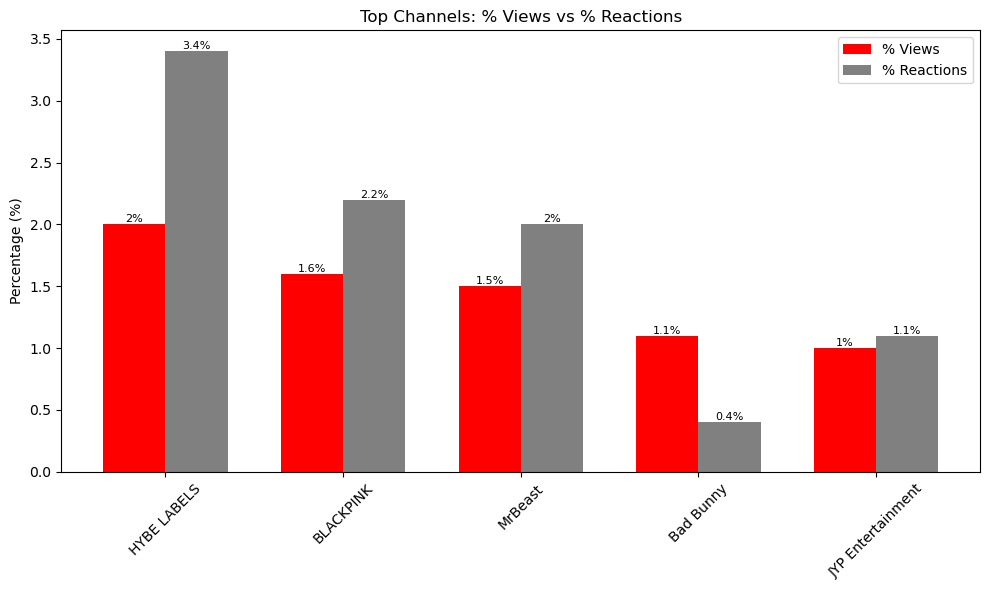

In [122]:
# Histogram with the Top Channels  in terms of % of Views with the % of Reactions:
import matplotlib.pyplot as plt
import numpy as np

top_channels = pivot_sum[['%_views', '%_reactions']] \
    .sort_values("%_views", ascending=False) \
    .head(5)

x = np.arange(len(top_channels.index))
width = 0.35

plt.figure(figsize=(10,6))

bars1 = plt.bar(x - width/2, top_channels['%_views'], width, label='% Views', color="red")
bars2 = plt.bar(x + width/2, top_channels['%_reactions'], width, label='% Reactions', color="grey")

plt.xticks(x, top_channels.index, rotation=45)
plt.ylabel("Percentage (%)")
plt.title("Top Channels: % Views vs % Reactions")
plt.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f'{height:g}%',
            ha='center',
            va='bottom',
            fontsize=8
        )

plt.tight_layout()
plt.show()

In [123]:
# Average for the the % reactions (likes+comments):
print(pivot_sum["%_reactions"].mean().round(4))
print(pivot_sum["%_views"].mean().round(4))

0.0059
0.006


### Hypothesis 3: 
#### - Some categories (e.g., Music/ Sport  vs. News) have significantly higher average views.
#### - The ratio of dislikes to total reactions (likes + dislikes) is the same across categories.


In [55]:
#2 bis/among these categories :  
# The ratio of dislikes to total reactions (likes + dislikes) is the same across categories.
pivot_sum = pd.pivot_table(
    df_new,
    values=["likes", "dislikes"],
    index="category_name",
    aggfunc="sum"
)

pivot_sum["total_reactions"] = (pivot_sum["likes"] + pivot_sum["dislikes"])
total_all = pivot_sum["total_reactions"].sum()
pivot_sum["%_reactions"] = (pivot_sum["total_reactions"] / total_all * 100).round()

pivot_sum["%_likes"] = (pivot_sum["likes"] / pivot_sum["total_reactions"] * 100).round()

pivot_sum["%_dislikes"] = (pivot_sum["dislikes"] / pivot_sum["total_reactions"] * 100).round()

pivot_sum[['%_reactions', '%_likes', '%_dislikes']].sort_values("%_dislikes", ascending=False)

,%_reactions,%_likes,%_dislikes
category_name,,,
News & Politics,0.0,91.0,9.0
Comedy,7.0,96.0,4.0
Howto & Style,2.0,96.0,4.0
Autos & Vehicles,1.0,97.0,3.0
Entertainment,23.0,97.0,3.0
Music,34.0,97.0,3.0
Nonprofits & Activism,0.0,97.0,3.0
People & Blogs,10.0,97.0,3.0
Science & Technology,3.0,97.0,3.0


In [ ]:
# Average for the the % reactions and dislikes:
print(pivot_sum["%_reactions"].mean().round())
print(pivot_sum["%_likes"].mean().round())
print(pivot_sum["%_dislikes"].mean().round())

7.0
97.0
3.0


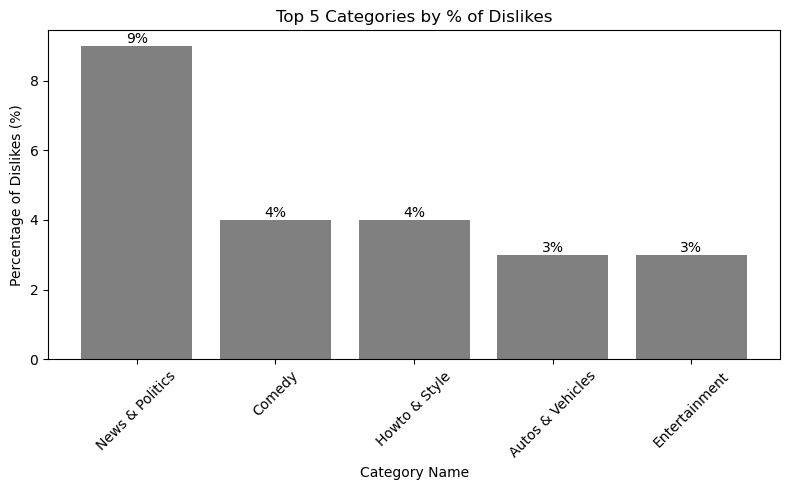

In [ ]:
# Histomgram to show the Top 5 Categories by % of Dislikes:
import matplotlib.pyplot as plt

top5 = pivot_sum['%_dislikes'].sort_values(ascending=False).head(5)

plt.figure(figsize=(8,5))
bars = plt.bar(top5.index, top5.values, color='grey')

plt.title("Top 5 Categories by % of Dislikes")
plt.ylabel("Percentage of Dislikes (%)")
plt.xlabel("Category Name")
plt.xticks(rotation=45)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{height:g}%',
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()

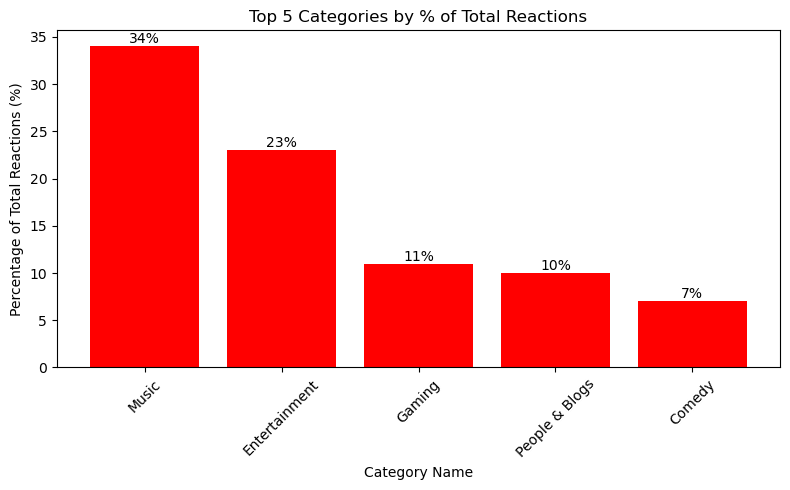

In [ ]:
# Histomgram to show the Top 5 Categories by % of Total Reactions:
import matplotlib.pyplot as plt

top5 = pivot_sum['%_reactions'].sort_values(ascending=False).head(5)

plt.figure(figsize=(8,5))
bars = plt.bar(top5.index, top5.values, color='red')

plt.title("Top 5 Categories by % of Total Reactions")
plt.ylabel("Percentage of Total Reactions (%)")
plt.xlabel("Category Name")
plt.xticks(rotation=45)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{height:g}%',
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()